# DOE 本番解析用 (doe-5)

In [1]:
import datetime
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

### Matplotlib のフォント設定（オプション）

In [2]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

## CSV ファイルの読込

In [3]:
name_doe = "doe-5"
name_code = "7011"
date_str = str(datetime.datetime.now().date())  # 保存ファイル目に付与する本日の日付
# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file_all = sorted(os.listdir(path_dir))
list_file = list_file_all  # ここで最新のデータに絞るかどうかを決める
print(list_file)
list_df = list()
for file in list_file:
    path = os.path.join(path_dir, file)
    list_df.append(pd.read_csv(path))
n_tick = len(list_df)
print(f"\n# of tick files : {n_tick}")
df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)

['ticks_20250819.csv', 'ticks_20250820.csv', 'ticks_20250821.csv', 'ticks_20250822.csv', 'ticks_20250825.csv', 'ticks_20250826.csv', 'ticks_20250827.csv', 'ticks_20250828.csv', 'ticks_20250829.csv', 'ticks_20250901.csv', 'ticks_20250902.csv', 'ticks_20250903.csv', 'ticks_20250904.csv', 'ticks_20250905.csv', 'ticks_20250908.csv', 'ticks_20250909.csv', 'ticks_20250910.csv', 'ticks_20250911.csv', 'ticks_20250912.csv', 'ticks_20250916.csv', 'ticks_20250917.csv', 'ticks_20250918.csv', 'ticks_20250919.csv', 'ticks_20250922.csv', 'ticks_20250924.csv', 'ticks_20250925.csv', 'ticks_20250926.csv', 'ticks_20250929.csv', 'ticks_20250930.csv', 'ticks_20251001.csv', 'ticks_20251002.csv', 'ticks_20251003.csv', 'ticks_20251006.csv', 'ticks_20251007.csv', 'ticks_20251008.csv', 'ticks_20251009.csv', 'ticks_20251010.csv', 'ticks_20251014.csv', 'ticks_20251015.csv', 'ticks_20251016.csv', 'ticks_20251017.csv', 'ticks_20251020.csv', 'ticks_20251021.csv', 'ticks_20251022.csv', 'ticks_20251023.csv', 'ticks_20

## サマリ集計

In [4]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
print(df_summary)

# HTML 形式で出力
styled = df_summary.style.format(
    {"trade": "{:.1f}", "total": "{:.2f}"}
).set_table_styles(
    [
        {"selector": "td", "props": "text-align: right;"},
    ]
)

html = styled.to_html()
with open("summary.html", "w", encoding="utf-8") as f:
    f.write(html)

    PERIOD_MA_1  PERIOD_MA_2      trade      total
0            30          300  32.344828   4.672414
1            30          400  26.413793   6.706897
2            30          500  24.517241  12.844828
3            30          600  22.379310  11.293103
4            30          700  21.172414   9.465517
5            60          300  22.310345  -1.379310
6            60          400  19.517241   2.310345
7            60          500  17.689655   9.189655
8            60          600  17.068966  10.241379
9            60          700  15.034483   7.000000
10           90          300  17.931034   0.396552
11           90          400  15.172414   0.724138
12           90          500  13.620690   8.948276
13           90          600  12.758621   8.965517
14           90          700  11.620690   8.310345
15          120          300  16.068966   2.137931
16          120          400  12.931034   6.586207
17          120          500  11.551724   9.586207
18          120          600  1

## 【収益】分散分析 (ANOVA)

In [5]:
# オリジナルのサマリデータをコピーして利用
df_anova = df_summary.copy()

# 因子列と応答変数
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
X = df_anova[factor_cols]
y = df_anova["total"]

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=factor_cols)

# 標準化した因子を df_anova に置き換え
for col in factor_cols:
    df_anova[col] = X_scaled_df[col]

# 二次交互作用まで含めるモデル
formula = "total ~ PERIOD_MA_1 + PERIOD_MA_2 + PERIOD_MA_1:PERIOD_MA_2"
model_2way = ols(formula, data=df_anova).fit()

# ANOVAテーブル
anova_table = sm.stats.anova_lm(model_2way, typ=2)
print("=== ANOVA (up to 2-way interactions) ===")
print(anova_table)

=== ANOVA (up to 2-way interactions) ===
                             sum_sq    df          F    PR(>F)
PERIOD_MA_1                0.941760   1.0   0.073590  0.788829
PERIOD_MA_2              146.618050   1.0  11.456815  0.002796
PERIOD_MA_1:PERIOD_MA_2    5.546837   1.0   0.433433  0.517463
Residual                 268.746504  21.0        NaN       NaN


### 主効果

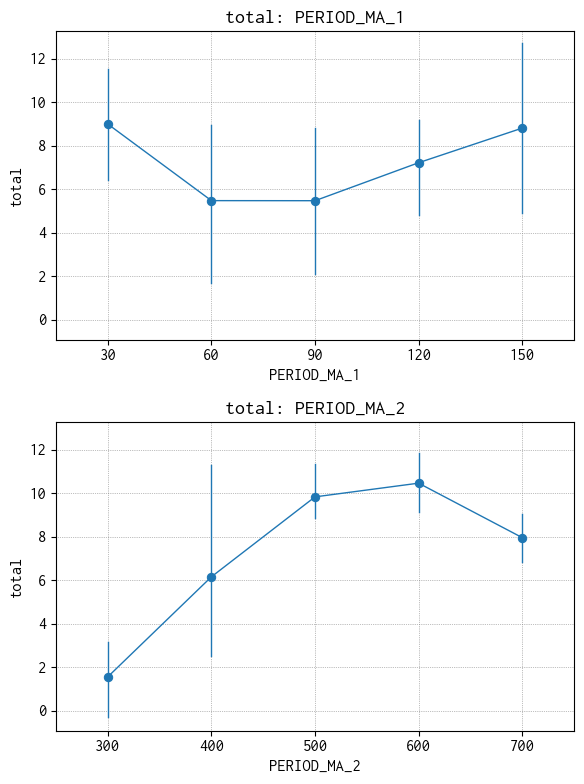

In [6]:
# === 各因子の平均効果を可視化 ===
list_col = ["PERIOD_MA_1", "PERIOD_MA_2"]
target = "total"
output = os.path.join(
    "..", "output", name_doe, f"{name_code}_doe_effects_main_{target}_{date_str}.png"
)

plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(len(list_col), 1, figsize=(6, 4 * len(list_col)))

y_min_global = 1e7
y_max_global = -1e7
for i, col in enumerate(list_col):
    sns.pointplot(
        x=col,
        y=target,
        data=df_summary,
        markersize=6,
        linewidth=1,
        errorbar="ci",
        ax=ax[i],
    )
    ax[i].grid(True, color="gray", linestyle="dotted", linewidth=0.5)
    ax[i].set_title(f"{target}: {col}")

    y_min, y_max = ax[i].get_ylim()
    if y_min < y_min_global:
        y_min_global = y_min
    if y_max_global < y_max:
        y_max_global = y_max

for i in range(len(list_col)):
    ax[i].set_ylim(y_min_global, y_max_global)

plt.tight_layout()
plt.savefig(output)
plt.show()

### 交互作用

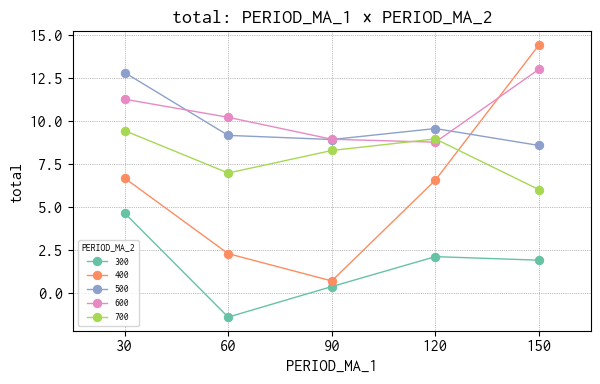

In [7]:
target = "total"
output = os.path.join(
    "..",
    "output",
    name_doe,
    f"{name_code}_doe_effects_interaction_{target}_{date_str}.png",
)
"""
pairs = [
    ("PERIOD_MA_1", "PERIOD_MA_2"),
]

a, b = pairs[0]
"""
a = "PERIOD_MA_1"
b = "PERIOD_MA_2"

plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.pointplot(
    x=a,
    y=target,
    hue=b,
    data=df_summary,
    markersize=6,
    linewidth=1,
    errorbar=None,
    palette="Set2",
    ax=ax,
)
ax.set_title(f"{target}: {a} × {b}")
ax.set_xlabel(a)
ax.set_ylabel(target)
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.5)

# 凡例のタイトル
lg = ax.legend(fontsize=7)
lg.set_title(b, prop={"size": 7})

plt.tight_layout()
plt.savefig(output)
plt.show()

## 【収益】重回帰分析 (MULREG)

In [8]:
# ---------------------------------------------------------
# 2. RSM 用の二次モデルを構築
#    total ~ PERIOD_MA_1 + PERIOD_MA_2 + 交互作用 + 二乗項
# ---------------------------------------------------------
formula = """
total ~ PERIOD_MA_1 + PERIOD_MA_2
        + I(PERIOD_MA_1**2) + I(PERIOD_MA_2**2)
        + PERIOD_MA_1:PERIOD_MA_2
"""
model = smf.ols(formula, data=df_summary).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     10.65
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           5.44e-05
Time:                        18:11:05   Log-Likelihood:                -54.099
No. Observations:                  25   AIC:                             120.2
Df Residuals:                      19   BIC:                             127.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [9]:
# ---------------------------------------------------------
# 3. 予測用のグリッドを作成して応答曲面を描く準備
# ---------------------------------------------------------
ma1_range = np.linspace(
    df_summary["PERIOD_MA_1"].min(), df_summary["PERIOD_MA_1"].max(), 100
)
ma2_range = np.linspace(
    df_summary["PERIOD_MA_2"].min(), df_summary["PERIOD_MA_2"].max(), 100
)
MA1, MA2 = np.meshgrid(ma1_range, ma2_range)

grid = pd.DataFrame({"PERIOD_MA_1": MA1.ravel(), "PERIOD_MA_2": MA2.ravel()})
grid["pred"] = model.predict(grid)

### 3D 応答曲面プロット

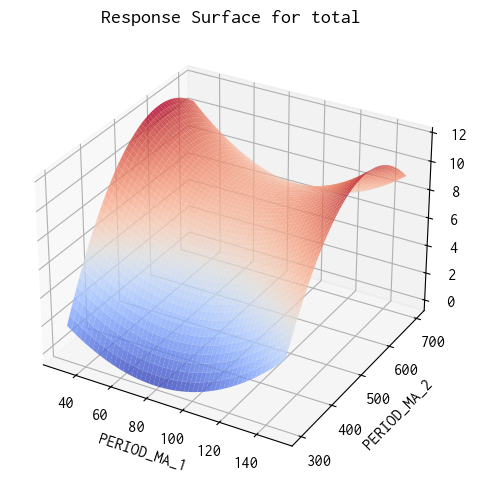

In [10]:
# ---------------------------------------------------------
# 4. 3D 応答曲面プロット（matplotlib）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    MA1, MA2, grid["pred"].values.reshape(MA1.shape), cmap="coolwarm", alpha=0.8
)

ax.set_xlabel("PERIOD_MA_1")
ax.set_ylabel("PERIOD_MA_2")
ax.set_title("Response Surface for total")

output = os.path.join(
    "..", "output", name_doe, f"{name_code}_rsm_surface_1_{target}_{date_str}.png"
)

plt.tight_layout()
plt.savefig(output)
plt.show()

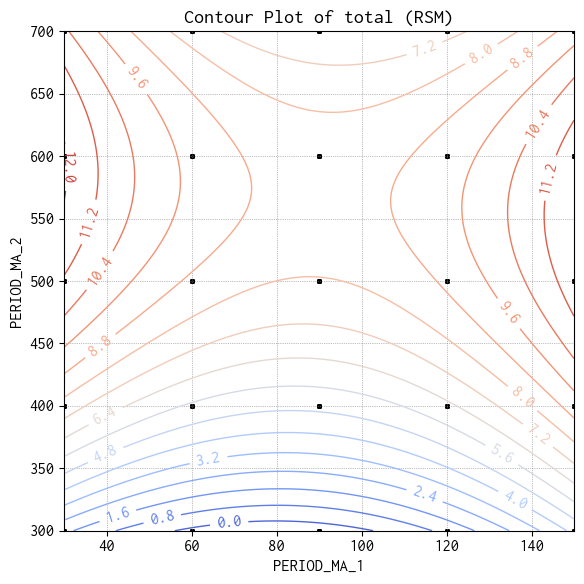

In [11]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

Z = grid["pred"].values.reshape(MA1.shape)

# 等高線（線にグラデーション）
cont = ax.contour(MA1, MA2, Z, levels=15, cmap="coolwarm", linewidths=1)

# 数値ラベル
ax.clabel(cont, inline=True, fontsize=12, fmt="%.1f")

ax.set_xlabel("PERIOD_MA_1")
ax.set_ylabel("PERIOD_MA_2")
ax.set_title("Contour Plot of total (RSM)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.5)

# 実験点を黒点で追加
ax.scatter(
    df["PERIOD_MA_1"], df["PERIOD_MA_2"], color="black", s=5, alpha=0.9  # 点の大きさ
)

# 最適点
# ax.scatter([90], [500], marker="o", facecolor="cyan", edgecolor="darkblue", s=200)

output = os.path.join(
    "..", "output", name_doe, f"{name_code}_rsm_contour_1_{target}_{date_str}.png"
)

plt.tight_layout()
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

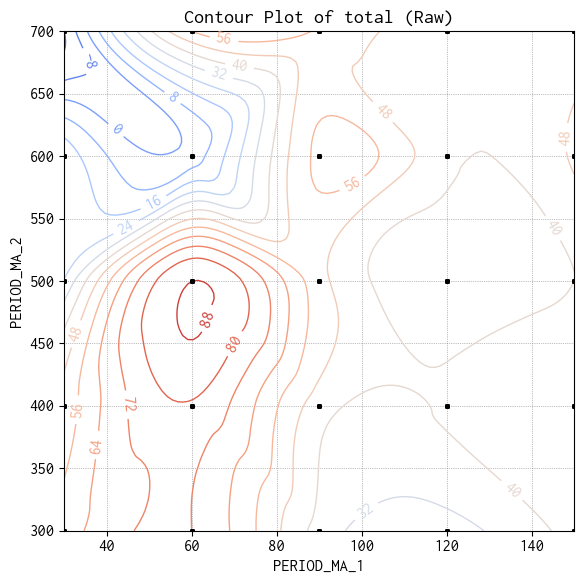

In [12]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# Contour Map
cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm", linewidths=1)
ax.clabel(cont, inline=True, fontsize=12)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title("Contour Plot of total (Raw)")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.5)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=5, zorder=3)

# 最適点
# ax.scatter([60], [500], marker="o", facecolor="cyan", edgecolor="darkblue", s=200)

output = os.path.join(
    "..", "output", name_doe, f"{name_code}_raw_contour_1_{target}_{date_str}.png"
)

plt.tight_layout()
plt.savefig(output)
plt.show()